In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


W1021 11:44:36.613052 140735584691072 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [2]:
friends_chars={} 
Rachel=[]
Ross=[]
Joey=[]
Chandler=[]
Phoebe=[]
Monica=[]
with open("transcripts_friends/season_all/merged.csv", "r+") as fp:
    for cnt, line in enumerate(fp):
        #print("Line {}: {}".format(cnt, line))
        if line.startswith('Rachel:'):
            Rachel.append(line[8:])
        elif line.startswith('Ross:'):
            Ross.append(line[6:])
        elif line.startswith('Monica:'):
            Monica.append(line[8:])
        elif line.startswith('Chandler:'):
            Chandler.append(line[10:])
        if line.startswith('Phoebe:'):
            Phoebe.append(line[8:])
        if line.startswith('Joey:'):
            Joey.append(line[6:])

friends_chars['RACHEL']=Rachel
friends_chars['ROSS']=Ross
friends_chars['MONICA']=Monica
friends_chars['PHOEBE']=Phoebe
friends_chars['CHANDLER']=Chandler
friends_chars['JOEY']=Joey

In [3]:
import pandas as pd
df6 = pd.DataFrame(friends_chars['MONICA'])
df5 = pd.DataFrame(friends_chars['ROSS'])

df4 = pd.DataFrame(friends_chars['RACHEL'])
df3 = pd.DataFrame(friends_chars['PHOEBE'])

df2 = pd.DataFrame(friends_chars['JOEY'])
df1 = pd.DataFrame(friends_chars['CHANDLER'])

In [4]:
df1.head()

,0
0,"You know, I'd love to, but I'm a little tired.\n"
1,You're on!\n
2,He could be alone. This morning I heard him do...
3,She's cheating on Joey with Ross!\n
4,Wow!\n


In [5]:
listOfScores1 = ['Chandler'] *df1.shape[0]
listOfScores2 = ['Joey'] *df2.shape[0]
listOfScores3 = ['Phoebe'] *df3.shape[0]
listOfScores4 = ['Rachel'] *df4.shape[0]
listOfScores5 = ['Ross'] *df5.shape[0]
listOfScores6 = ['Monica'] *df6.shape[0]


In [6]:
df1['Score'] = listOfScores1
df2['Score'] = listOfScores2 
df3['Score'] = listOfScores3
df4['Score'] = listOfScores4
df5['Score'] = listOfScores5
df6['Score'] = listOfScores6

In [7]:
df1=df1.rename(columns={0: 'dialogue'})
df2=df2.rename(columns={0: 'dialogue'})
df3=df3.rename(columns={0: 'dialogue'})
df4=df4.rename(columns={0: 'dialogue'})
df5=df5.rename(columns={0: 'dialogue'})
df6=df6.rename(columns={0: 'dialogue'})

In [8]:
df = pd.concat([df1, df2,df3,df4,df5,df6])
df.tail()

,dialogue,Score
16323,But... you suck!\n,Monica
16324,Oh my God! You're good!\n,Monica
16325,(to Chandler) Oh my God. That was so amazing! ...,Monica
16326,Why?\n,Monica
16327,This is so great! Now we can enter into double...,Monica


In [9]:
from io import StringIO
col = ['Score', 'dialogue']
df = df[col]
df = df[pd.notnull(df['dialogue'])]
df.columns = ['Score', 'dialogue']
df['category_id'] = df['Score'].factorize()[0]
category_id_df = df[['Score', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Score']].values)
df.tail()

,Score,dialogue,category_id
16323,Monica,But... you suck!\n,5
16324,Monica,Oh my God! You're good!\n,5
16325,Monica,(to Chandler) Oh my God. That was so amazing! ...,5
16326,Monica,Why?\n,5
16327,Monica,This is so great! Now we can enter into double...,5


In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

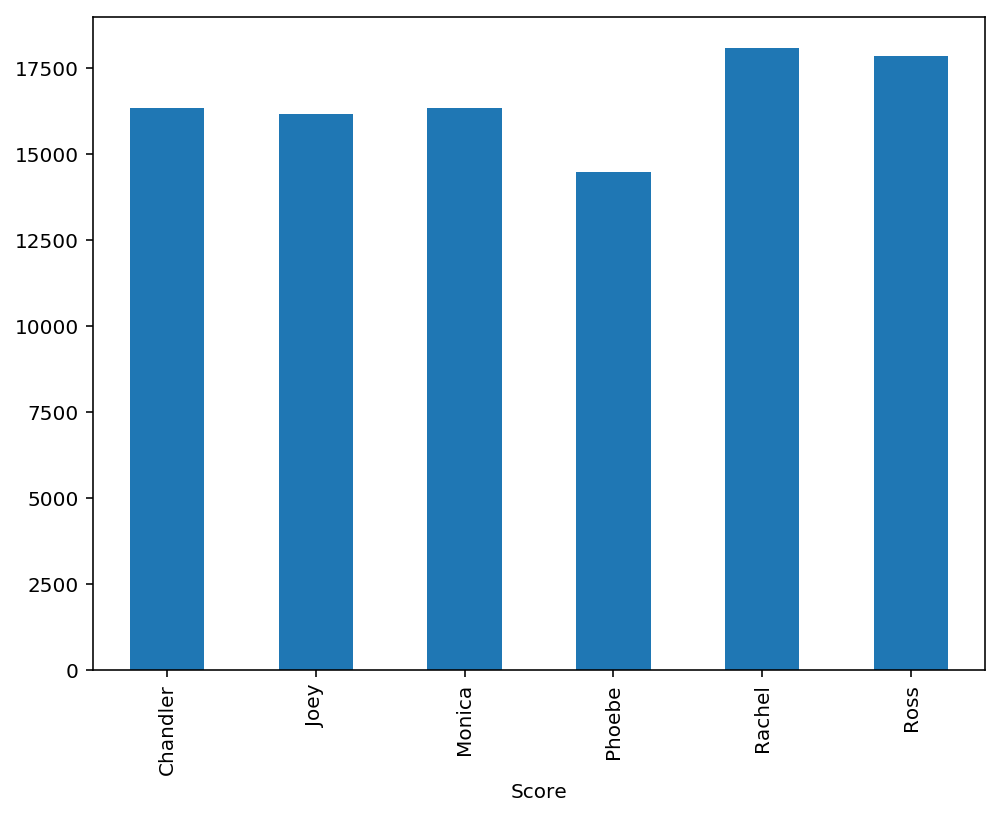

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Score').dialogue.count().plot.bar(ylim=0)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['dialogue'], df['category_id'], test_size=0.33, random_state=42)
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [13]:
y_train.shape

(66486,)

In [14]:
X_train.shape

(66486,)

In [15]:
X_test.shape

(32747,)

In [16]:
y_test.shape

(32747,)

In [17]:
X_train

2418          So you're gonna have to do it in the mess!\n
6128                 Were you the ones called the cops?!\n
12328    Hmmm, soup! (Tries again.) Hmm soup! (Tries ag...
2581     And I gotta pay rent! Look, how-how about this...
12970                                              Okay.\n
6391     Yes, I know! And Joey knows! But Ross doesn't ...
5163                   I’m gonna ask Monica to marry me.\n
5576     I gotcha. Sorry. (To Monica) So, did you ever ...
282                                         O-oh my God!\n
2458     All right. I’m gonna go to the fertility docto...
14124                              Die Hard still great!\n
4529             Rach, what uh, what are you doing here?\n
9499                                   Thank you, buddy.\n
13951    Are you kidding. He is so considerate of my fe...
5625                                    But I hired you!\n
12311                                This is disgusting!\n
17247    Hey... there's sensitive... and there is too s.

In [26]:
vocab_size = 30000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
# sequences = tokenizer.texts_to_sequences(training_sentences)
# padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)





In [27]:
MAX_SEQUENCE_LENGTH = 120
X = tokenizer.texts_to_sequences(X_train.values)#df['Dialogue']#tokenizer.texts_to_sequences(df['Dialogue'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (66486, 120)


array([[   0,    0,    0, ...,   15,    4, 1031],
       [   0,    0,    0, ...,  367,    4, 2966],
       [   0,    0,    0, ...,   15,  441, 1222],
       ...,
       [   0,    0,    0, ...,    0,    0,  441],
       [   0,    0,    0, ...,   21,  326,  274],
       [   0,    0,    0, ...,    0,    0,   38]], dtype=int32)

In [28]:
x_test=tokenizer.texts_to_sequences(X_test.values)#df['Dialogue']#tokenizer.texts_to_sequences(df['Dialogue'].values)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_test.shape)
x_test

Shape of data tensor: (32747, 120)


array([[    0,     0,     0, ...,    43, 14546, 14547],
       [    0,     0,     0, ...,    91,    35,   702],
       [    0,     0,     0, ...,   121,    67,   108],
       ...,
       [    0,     0,     0, ...,    55,   265,    29],
       [    0,     0,     0, ...,    27,   513,    61],
       [    0,     0,     0, ...,    23,   322,  3129]], dtype=int32)

In [29]:
Y = pd.get_dummies(y_train).values#df['category_id']
#print('Shape of label tensor:', Y.shape)
Y

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [30]:
y_test = pd.get_dummies(y_test).values#df['category_id']
#print('Shape of label tensor:', Y.shape)
y_test

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [45]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# print(decode_review(padded[1]))
# print(training_sentences[1])

In [32]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 64


from tensorflow.keras.callbacks import EarlyStopping

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(tf.keras.layers.SpatialDropout1D(0.2))
model1.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model1.add(tf.keras.layers.Dense(6, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model1.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

W1021 11:54:51.815622 140735584691072 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 59837 samples, validate on 6649 samples
Epoch 1/10
59837/59837 [==============================] - 67s 1ms/sample - loss: 1.7307 - accuracy: 0.2559 - val_loss: 1.6426 - val_accuracy: 0.3246
Epoch 2/10
59837/59837 [==============================] - 67s 1ms/sample - loss: 1.5211 - accuracy: 0.4000 - val_loss: 1.5378 - val_accuracy: 0.3846
Epoch 3/10
59837/59837 [==============================] - 65s 1ms/sample - loss: 1.3571 - accuracy: 0.4706 - val_loss: 1.4784 - val_accuracy: 0.4204
Epoch 4/10
59837/59837 [==============================] - 67s 1ms/sample - loss: 1.2525 - accuracy: 0.5119 - val_loss: 1.4485 - val_accuracy: 0.4369
Epoch 5/10
59837/59837 [==============================] - 73s 1ms/sample - loss: 1.1795 - accuracy: 0.5373 - val_loss: 1.4333 - val_accuracy: 0.4516
Epoch 6/10
59837/59837 [==============================] - 71s 1ms/sample - loss: 1.1218 - accuracy: 0.5605 - val_loss: 1.4177 - val_accuracy: 0.4659
Epoch 7/10
59837/59837 [==============================] -

In [35]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 64


from tensorflow.keras.callbacks import EarlyStopping

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(tf.keras.layers.SpatialDropout1D(0.2))
model1.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model1.add(tf.keras.layers.Dense(6, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model1.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

W1018 13:44:32.937334 140735584691072 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 59837 samples, validate on 6649 samples
Epoch 1/10
59837/59837 [==============================] - 68s 1ms/sample - loss: 1.7321 - accuracy: 0.2568 - val_loss: 1.6374 - val_accuracy: 0.3301
Epoch 2/10
59837/59837 [==============================] - 67s 1ms/sample - loss: 1.5169 - accuracy: 0.4048 - val_loss: 1.5320 - val_accuracy: 0.3906
Epoch 3/10
59837/59837 [==============================] - 67s 1ms/sample - loss: 1.3560 - accuracy: 0.4716 - val_loss: 1.4791 - val_accuracy: 0.4211
Epoch 4/10
59837/59837 [==============================] - 65s 1ms/sample - loss: 1.2565 - accuracy: 0.5100 - val_loss: 1.4558 - val_accuracy: 0.4339
Epoch 5/10
59837/59837 [==============================] - 67s 1ms/sample - loss: 1.1836 - accuracy: 0.5374 - val_loss: 1.4303 - val_accuracy: 0.4503
Epoch 6/10
59837/59837 [==============================] - 65s 1ms/sample - loss: 1.1247 - accuracy: 0.5597 - val_loss: 1.4233 - val_accuracy: 0.4677
Epoch 7/10
59837/59837 [==============================] -

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Dense(6, activation='sigmoid')
# ])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()


In [ ]:
# num_epochs = 10
# model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

In [34]:
y_pred = model1.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
y_pred


array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

In [35]:
y_test

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

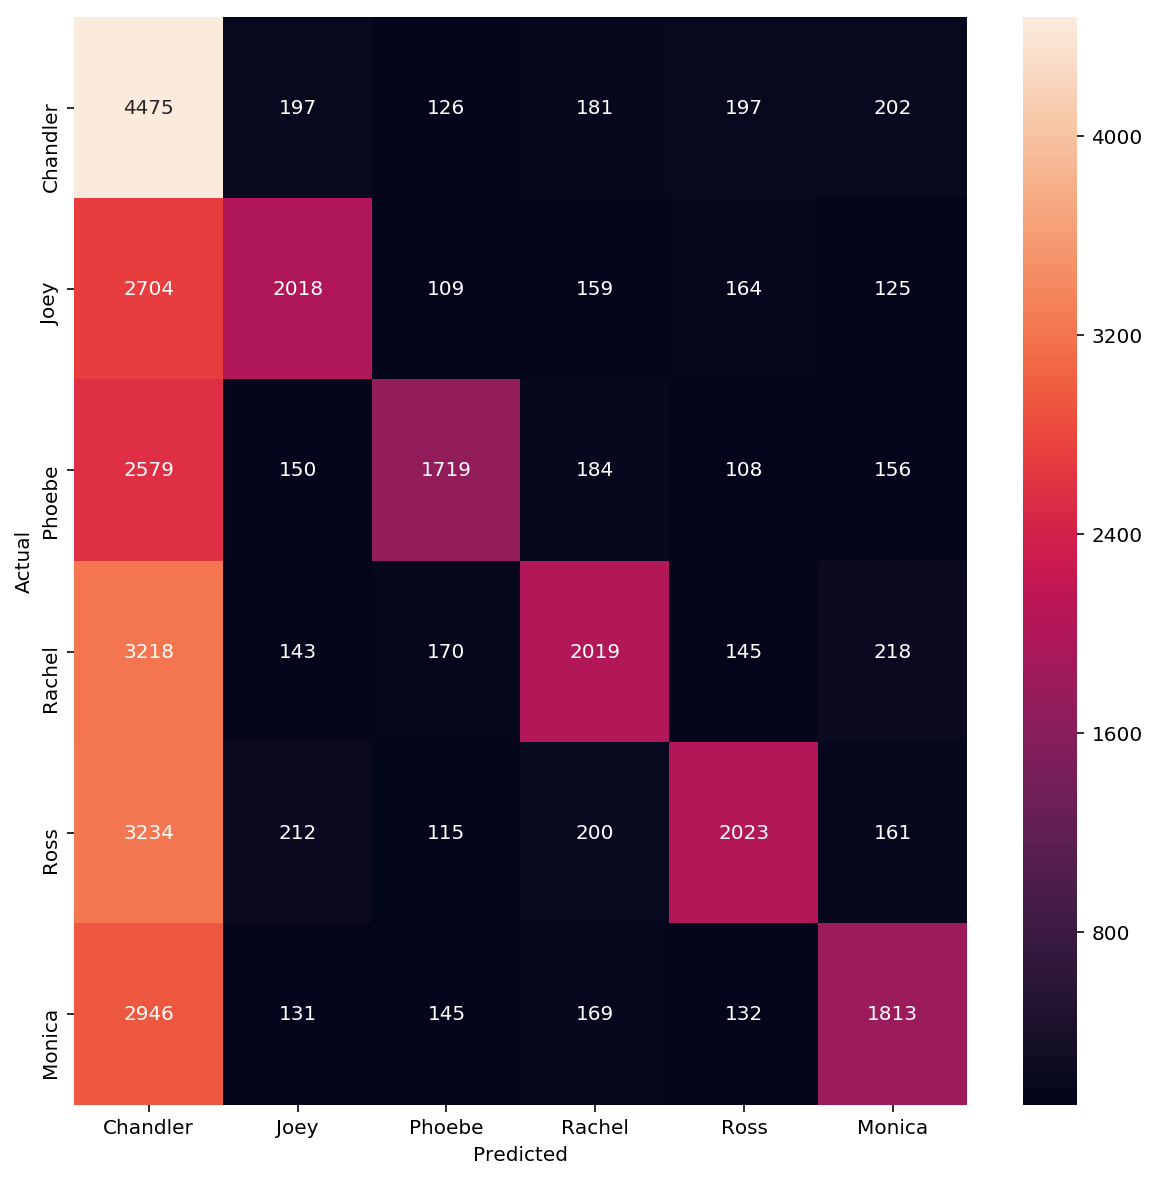

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = confusion_matrix(
    y_test.argmax(axis=1), y_pred.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Score.values, yticklabels=category_id_df.Score.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####stuck here#####

In [40]:
e = model1.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(20000, 64)


In [46]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, len(reverse_word_index)):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [47]:


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [48]:
sentence = "You’re gonna mess it up let me do it."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)

[[1172], [723], [1583], [674], [1879], [621], [], [2130], [723], [1605], [1605], [6], [], [1824], [621], [1088], [1088], [], [2], [1424], [], [1583], [2740], [], [1897], [621], [1424], [], [1824], [621], [], [2067], [723], [], [2], [1424], []]


In [49]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Score'].unique()))

              precision    recall  f1-score   support

    Chandler       0.73      0.34      0.46      5378
        Joey       0.71      0.38      0.50      5279
      Phoebe       0.72      0.35      0.47      4896
      Rachel       0.69      0.34      0.46      5913
        Ross       0.73      0.34      0.46      5945
      Monica       0.68      0.34      0.45      5336

   micro avg       0.71      0.35      0.47     32747
   macro avg       0.71      0.35      0.47     32747
weighted avg       0.71      0.35      0.47     32747
 samples avg       0.35      0.35      0.35     32747



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [50]:
pip install --upgrade gensim

     |████████████████████████████████| 24.7MB 13.1MB/s eta 0:00:01
  Found existing installation: gensim 3.8.0
    Uninstalling gensim-3.8.0:
      Successfully uninstalled gensim-3.8.0
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [52]:
from gensim.models import Word2Vec, KeyedVectors

model = Word2Vec(X_train)

W1021 14:34:04.192557 140735584691072 word2vec.py:1567] Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.


In [55]:
words = list(model.wv.vocab)
print(words)

['S', 'o', ' ', 'y', 'u', "'", 'r', 'e', 'g', 'n', 'a', 'h', 'v', 't', 'd', 'i', 'm', 's', '!', '\n', 'W', 'c', 'l', 'p', '?', 'H', ',', '(', 'T', '.', ')', 'w', 'A', 'I', 'L', 'k', '-', 'b', 'Y', '’', 'f', 'O', 'J', 'B', 'R', 'M', 'G', 'F', 'D', '…', 'C', '2', '0', 'x', 'q', 'P', '"', 'N', 'U', 'j', 'K', 'X', '‘', 'E', '4', '1', 'z', '7', '3', ';', '$', '5', '—', '<', '>', 'V', '�', '9', ':', '/', '[', ']', '6', '8', '“', '”', 'Q', 'Z', '&', 'é', '*', '%', '{', '}', '`', '–']


In [59]:
model.wv.save_word2vec_format('model.bin')

In [60]:
model.wv.save_word2vec_format('model.txt', binary=False)

In [63]:
# train model
model = Word2Vec(X_train, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word

# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

W1021 16:35:30.901831 140735584691072 word2vec.py:1567] Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.


Word2Vec(vocab=104, size=100, alpha=0.025)
['S', 'o', ' ', 'y', 'u', "'", 'r', 'e', 'g', 'n', 'a', 'h', 'v', 't', 'd', 'i', 'm', 's', '!', '\n', 'W', 'c', 'l', 'p', '?', 'H', ',', '(', 'T', '.', ')', 'w', 'A', 'I', 'L', 'k', '-', 'b', 'Y', '’', 'f', 'O', 'J', 'B', 'R', 'M', 'G', 'F', 'D', '…', 'C', '2', '0', 'x', 'q', 'P', '"', 'N', 'U', 'j', 'K', 'X', '‘', 'E', '4', '1', 'z', '7', '3', ';', '$', '5', '—', '<', '>', 'V', '�', '9', ':', '/', '[', ']', '6', '8', '“', '”', 'Q', 'Z', '&', 'é', '*', '%', '|', '{', '}', 'ç', '_', '+', '`', '–', '#', 'É', 'è', '\xad']
Word2Vec(vocab=104, size=100, alpha=0.025)


In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [66]:
tokenizer.fit_on_texts(X_train)